
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN + LSTM)</font> </center>**

## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Visualize the Data with its Labels**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**

- **`Step 5:` implement the LRCN Approach**
 
    - **`Step 5.1:` Construct the Model**
    
    - **`Step 5.2:` Compile & Train the Model**
    
    - **`Step 5.3:` Plot Model’s Loss & Accuracy Curves**

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [1]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/a7/9e/7110d2c5d543ab03b9581dbb1f8e2429863e44e0c9b4960b766f230c1279/opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for youtube-dl from https://files.pythonhosted.org/packages/40/93/65c208f51895f74bbfea1423974c54fff1d1c4e9a97ebee1011b021554b8/youtube_dl-2021.12.17-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     --- ----------------------------------- 30.7/388.3 kB 1.4 MB/s eta 0:00:01
     --- ----------------------------------- 30.7/388.3 kB 1.4 MB/s eta 0:00:01
     --- --------------------------------- 41.0/388.3 kB 281.8 kB/s eta 0:00:02
     ------- ----------------------------- 81.9/388.3 kB 416.7 kB/s eta 0:00:01
     -------- ---------------------------- 92.2/388.3 kB 374.1 kB/s eta 0:00:01
     ---------- ------------------------- 112.6/388.3 kB 409.6 kB/s eta 0:0

DEPRECATION: Loading egg at c:\users\avikh\anaconda3\lib\site-packages\finrl-0.3.6-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


  Cloning https://github.com/TahaAnwar/pafy.git to c:\users\avikh\appdata\local\temp\pip-install-dz23zx0p\pafy_a9a5135582d34244b27a2c5e98639449
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=36023 sha256=30553c7effe746d4230e075dd1cfec4f68f7bd07be0cf8dd3233e52afd4b1aeb
  Stored in directory: C:\Users\avikh\AppData\Local\Temp\pip-ephem-wheel-cache-4p1mm2t0\wheels\5d\10\b2\201d5ae22a768418524564d620a38e1d738c1c02907909dee5
Successfully built pafy


DEPRECATION: Loading egg at c:\users\avikh\anaconda3\lib\site-packages\finrl-0.3.6-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git 'C:\Users\avikh\AppData\Local\Temp\pip-install-dz23zx0p\pafy_a9a5135582d34244b27a2c5e98639449'


In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

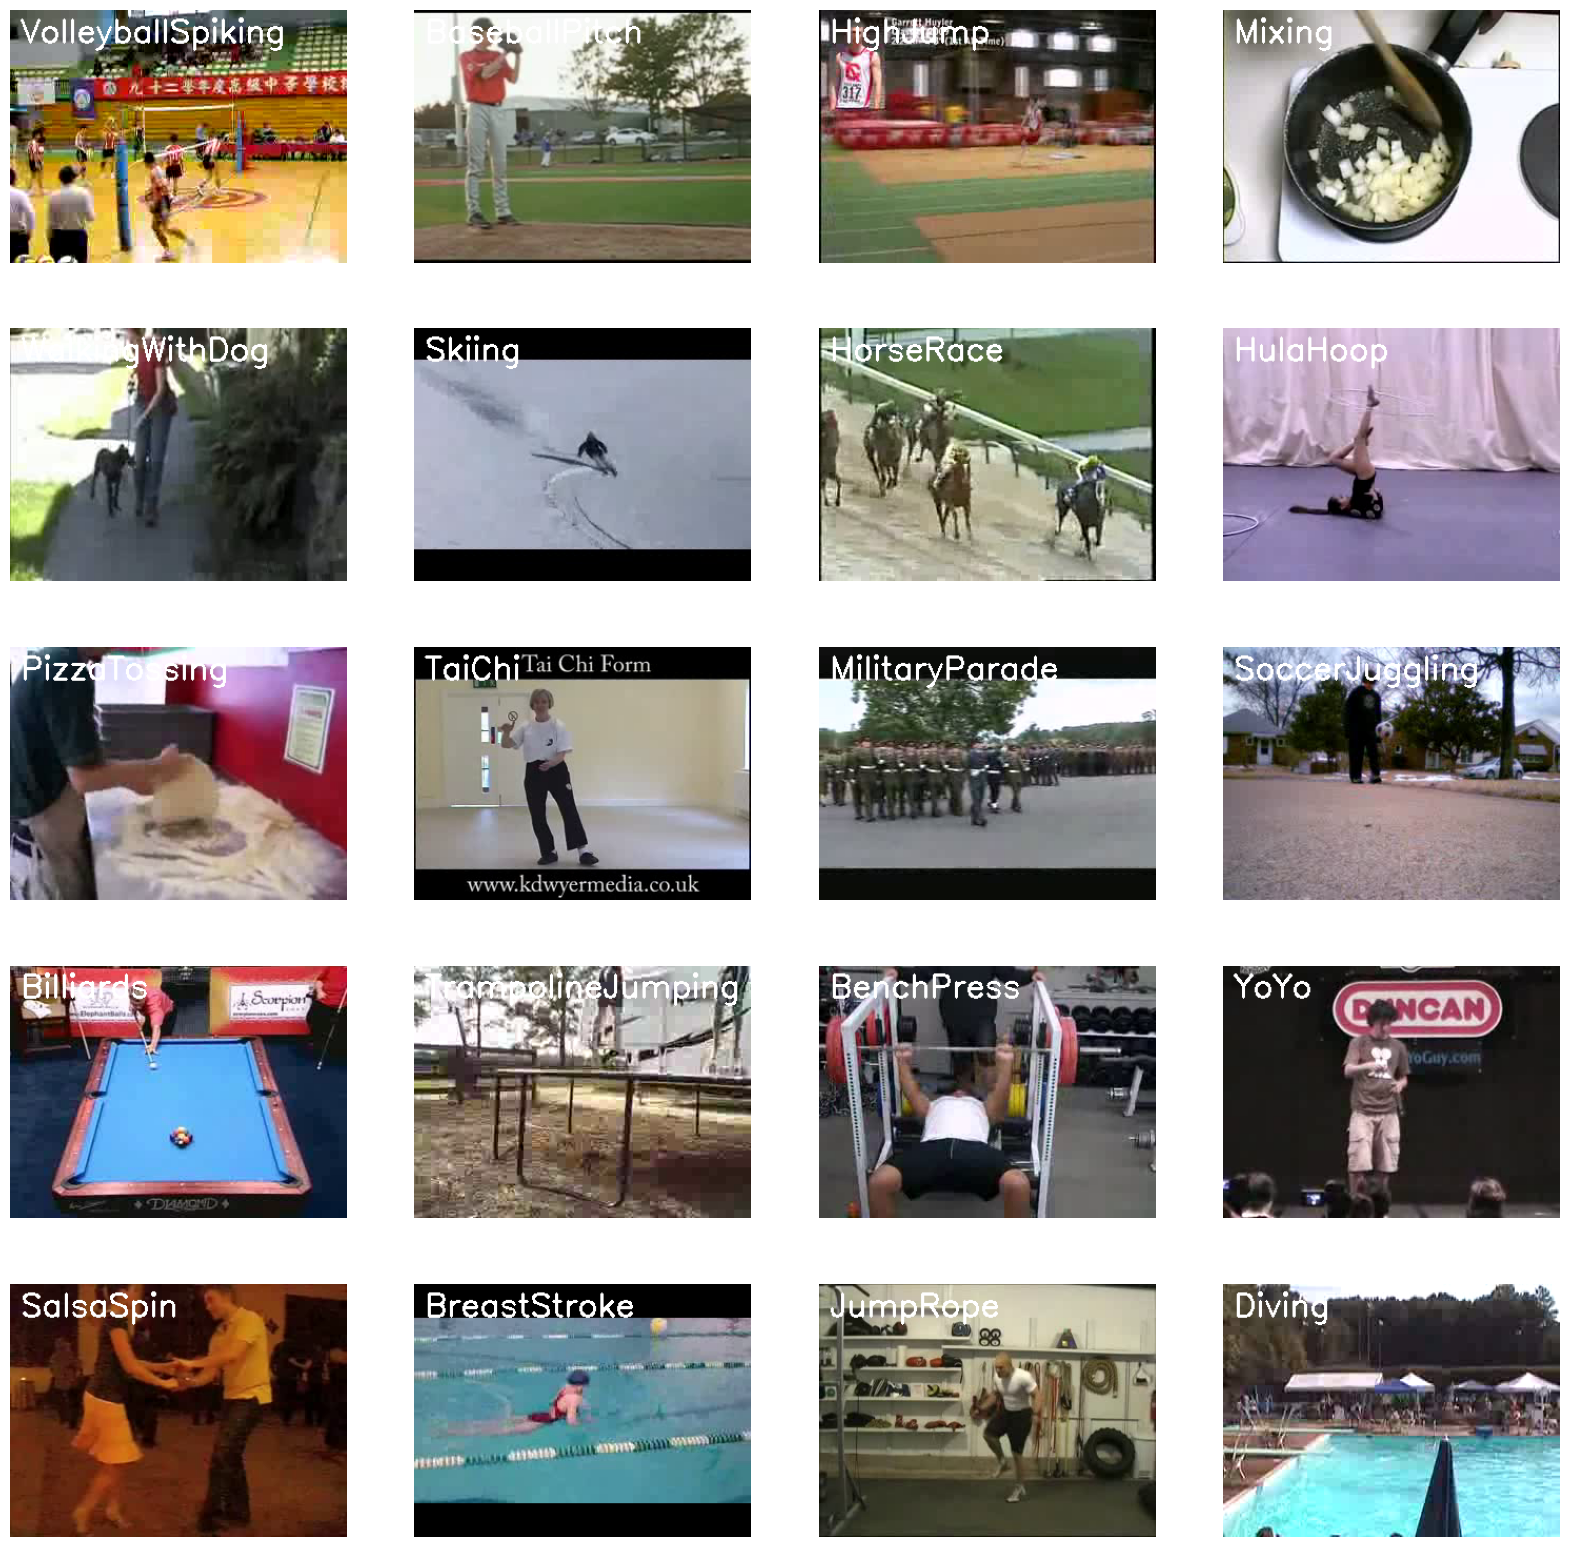

In [58]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

In [94]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = all_classes_names[:20]

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

In [95]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

In [96]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [97]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Kayaking


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [98]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

In [99]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**

### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**

In [100]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [101]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D  (None, 20, 62, 62, 4)     1024      
 )                                                               
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 20, 31, 31, 4)     0         
 ng3D)                                                           
                                                                 
 time_distributed_45 (TimeD  (None, 20, 31, 31, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_13 (ConvLSTM2D  (None, 20, 29, 29, 8)     3488      
 )                                                               
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 20, 15, 15, 8)    

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [102]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
414/414 [==============================] - 631s 1s/step - loss: 2.4607 - accuracy: 0.2403 - val_loss: 2.0773 - val_accuracy: 0.3406
Epoch 2/50
414/414 [==============================] - 583s 1s/step - loss: 0.0939 - accuracy: 0.9764 - val_loss: 1.0913 - val_accuracy: 0.7488


#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

In [127]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

22/22 [==============================] - 13s 598ms/step - loss: 0.9048 - accuracy: 0.7294


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [116]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**

In [117]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

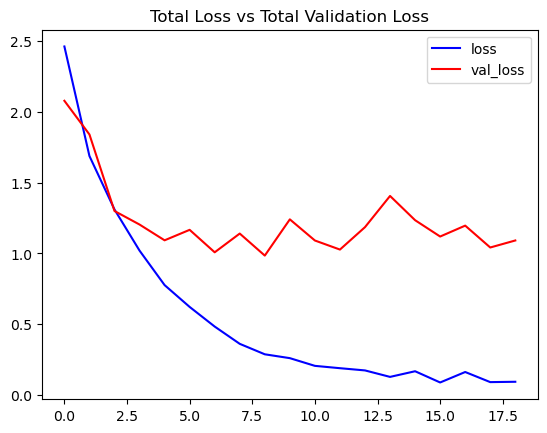

In [118]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

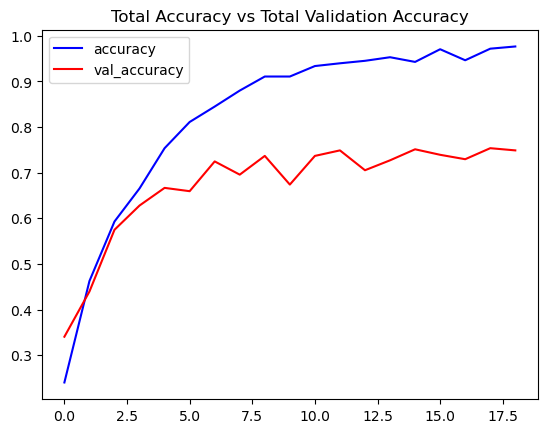

In [119]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

In [120]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [121]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_61 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_62 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_63 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_64 (TimeD  (None, 20, 4, 4, 32)     

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**

In [122]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
414/414 [==============================] - 58s 94ms/step - loss: 2.8534 - accuracy: 0.1232 - val_loss: 2.4755 - val_accuracy: 0.1981
Epoch 2/70
414/414 [==============================] - 28s 69ms/step - loss: 2.3803 - accuracy: 0.2470 - val_loss: 2.2568 - val_accuracy: 0.2995
Epoch 3/70
414/414 [==============================] - 28s 68ms/step - loss: 2.1522 - accuracy: 0.3043 - val_loss: 2.0572 - val_accuracy: 0.3043
Epoch 4/70
414/414 [==============================] - 29s 69ms/step - loss: 1.9778 - accuracy: 0.3786 - val_loss: 1.8702 - val_accuracy: 0.4130
Epoch 5/70
414/414 [==============================] - 28s 68ms/step - loss: 1.7656 - accuracy: 0.4324 - val_loss: 1.7002 - val_accuracy: 0.4444
Epoch 6/70
414/414 [==============================] - 28s 68ms/step - loss: 1.6479 - accuracy: 0.4789 - val_loss: 1.5723 - val_accuracy: 0.5048
Epoch 7/70
414/414 [==============================] - 28s 66ms/step - loss: 1.4744 - accuracy: 0.5417 - val_loss: 1.4937 - val_accuracy:

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

In [123]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

22/22 [==============================] - 3s 68ms/step - loss: 0.3296 - accuracy: 0.9132


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [124]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

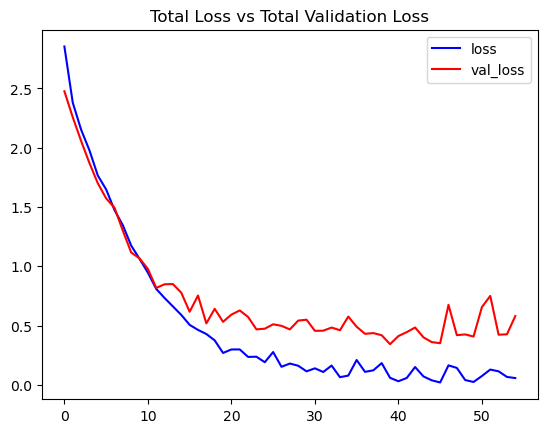

In [125]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

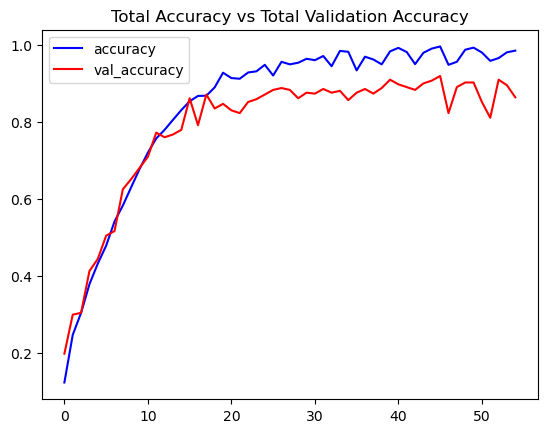

In [126]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')